# Analyse camera tracking data

### created by Chagas, Andre M 
### Distributed under CC BY SA 4.0 20200310

---

all paths are described in relation to the location of the jupyter notebook.

In [3]:
#import necessary libraries
import os

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import support

In [29]:
#location of csv files:
csvPath = "..//..//test_data//csvs//"

#select which animal to analyse
animalFolder = ""

#get a list of the files so they can be analysed in a batch:
csvFiles = [f for f in os.listdir(csvPath+animalFolder) if os.path.isfile(os.path.join(csvPath, f))]
print(csvFiles)


['all_data.csv', 'all_data26.csv', 'all_data3.csv', 'arya_trimmed.csv']


In [10]:
test = pd.DataFrame()
test = test.join(pd.DataFrame([1,2,3]))
test = test.join(pd.DataFrame([4,5,6]))
test

ValueError: columns overlap but no suffix specified: Int64Index([0], dtype='int64')

In [3]:
# set the file path 

#filepath = "/mnt/d/repositories/rodent-tracking/test_data/all_data.csv"
fid = pd.DataFrame()
for item in csvFiles:
    fid = pd.read_csv(filepath)
    fid = support.rename_rows(fid)
#print(fid)




wheelmoving
wheel.Item1.wheelROI.X
wheel.Item1.wheelROI.Y
wheel.Item1.wheelROI.Width
wheel.Item1.wheelROI.Height
wheel.Item2.wheel.Centroid.X
wheel.Item2.wheel.Centroid.Y
wheel.Item2.wheel.Orientation
wheel.Item2.wheel.MajorAxisLength
wheel.Item2.wheel.MinorAxisLength
wheel.Item2.wheel.Area
mousemoving
mouse.Item1.mouse.Centroid.X
mouse.Item1.mouse.Centroid.Y
mouse.Item1.mouse.Orientation
mouse.Item1.mouse.MajorAxisLength
mouse.Item1.mouse.MinorAxisLength
mouse.Item1.mouse.Area
mouse.Item2.mouseROI.X
mouse.Item2.mouseROI.Y
mouse.Item2.mouseROI.Width
mouse.Item2.mouseROI.Height
frameinterval
timestamp


---
**travelled distance**


if there was only the mouse on the cage, the travelled distance would be: 
- given by pythagoras a2 = b2 + c2 for where b and c are x and y dimensions, and their magnitude is the difference between 2 consecutive frames.

But the mouse has a wheel in its cage, so we need to add the "distance" the wheel
travelled to the distance travelled by the animal (since while running on the wheel,
the animal is static in relation to the cage and camera).

so in the end we want the distance travelled by the mouse while it was NOT on 
the wheel, plus the distance travelled by the wheel, while the wheel was moving


In [4]:
pd.Series(data = (fid["mousemoving"] & ~fid["wheelmoving"]),name="onlymouse")

0       False
1       False
2       False
3       False
4       False
        ...  
8936    False
8937    False
8938    False
8939    False
8940     True
Name: onlymouse, Length: 8941, dtype: bool

In [5]:
### mouse distance X when wheel was NOT moving
#get boolean array for when mouse is moving, but wheel is not:
fid  = fid.join(pd.Series(data = (fid["mousemoving"] & ~fid["wheelmoving"]),name="onlymouse"))
#print(fid["onlymouse"])

In [6]:


### mouse distance X 
mouseXdist = fid["mouse.Item1.mouse.Centroid.X"].diff()
### mouse distance Y 
mouseYdist = fid["mouse.Item1.mouse.Centroid.Y"].diff()



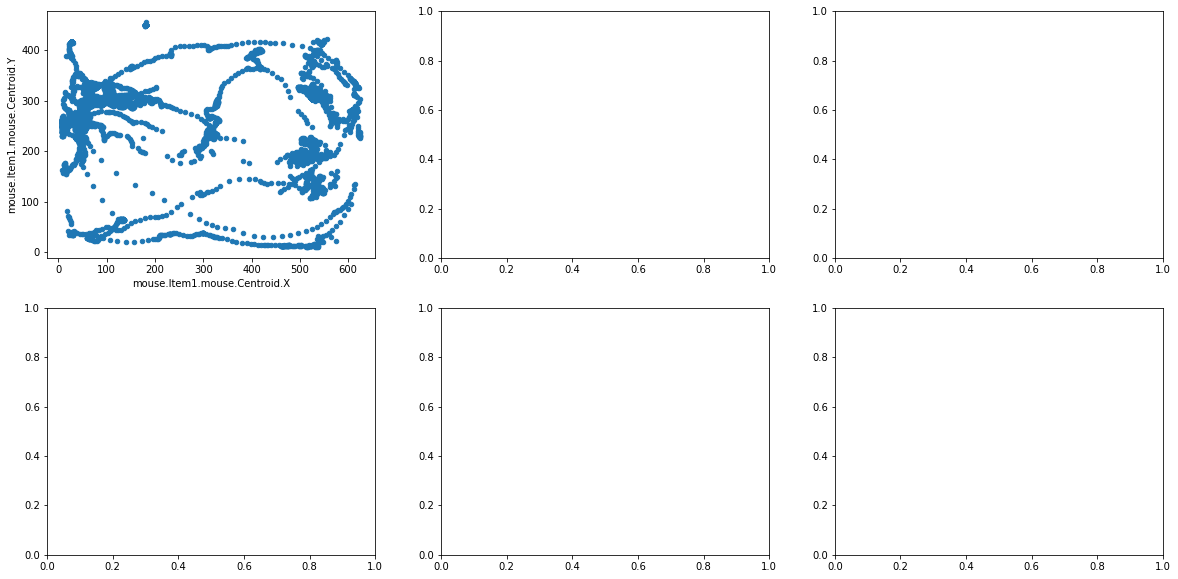

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (20, 10))

fid.plot(x="mouse.Item1.mouse.Centroid.X",
         y="mouse.Item1.mouse.Centroid.Y",
         kind="scatter",
         ax=axes[0,0])




In [19]:
fid.keys()

Index(['wheelmoving', 'wheel.Item1.wheelROI.X', 'wheel.Item1.wheelROI.Y',
       'wheel.Item1.wheelROI.Width', 'wheel.Item1.wheelROI.Height',
       'wheel.Item2.wheel.Centroid.X', 'wheel.Item2.wheel.Centroid.Y',
       'wheel.Item2.wheel.Orientation', 'wheel.Item2.wheel.MajorAxisLength',
       'wheel.Item2.wheel.MinorAxisLength', 'wheel.Item2.wheel.Area',
       'mousemoving', 'mouse.Item1.mouse.Centroid.X',
       'mouse.Item1.mouse.Centroid.Y', 'mouse.Item1.mouse.Orientation',
       'mouse.Item1.mouse.MajorAxisLength',
       'mouse.Item1.mouse.MinorAxisLength', 'mouse.Item1.mouse.Area',
       'mouse.Item2.mouseROI.X', 'mouse.Item2.mouseROI.Y',
       'mouse.Item2.mouseROI.Width', 'mouse.Item2.mouseROI.Height',
       'frameinterval', 'timestamp', 'onlymouse'],
      dtype='object')

In [21]:
# mouse movement (excluding the times when the mouse was on the wheel) using pythagoras 
onlyMouseDist = np.sqrt((mouseXdist[fid["onlymouse"]]**2)+(mouseYdist[fid["onlymouse"]]**2)) 
onlyMouseDist = onlyMouseDist.sum()
print(onlyMouseDist)
#plt.plot(onlyMouseDist)

0.0


---

#### before calculating the rest of total movement, we need to make some considerations on the wheel movement:




**calculate distance travelled while on the wheel**

The wheel has a black marker that is used to track its movement. the tracker is set close to the center of the wheel and the readings we have to work with are X and Y positions of this tracker in relation to the bottom left corner of the WheelROI (the next cell plots the raw data for better visualisation)

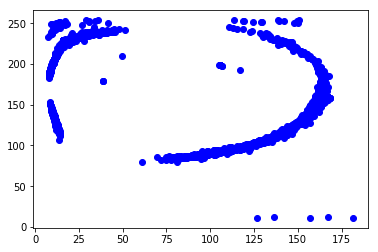

In [10]:
plt.plot(fid["wheel.Item2.wheel.Centroid.X"],fid["wheel.Item2.wheel.Centroid.Y"],'bo')

the above graph shows all detected X against Y positions of the wheel marker (this is a bit noisy at the moment, but can/should be cleaned up using bonsai). Gap on the top can happen because of a glare from the IR light from the camera leds.

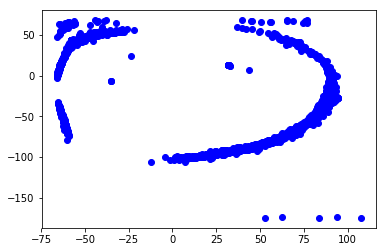

In [11]:
# get the x and y average positions are remove them from each dimension, so to "center" the wheel
wheelXavg = fid["wheel.Item2.wheel.Centroid.X"].mean()
wheelYavg = fid["wheel.Item2.wheel.Centroid.Y"].mean()


fid = fid.join(pd.Series(data = (fid["wheel.Item2.wheel.Centroid.X"]-wheelXavg),name="wheelXcentered"))
fid = fid.join(pd.Series(data = (fid["wheel.Item2.wheel.Centroid.Y"]-wheelYavg),name="wheelYcentered"))


plt.plot(fid["wheel.Item2.wheel.Centroid.X"]-wheelXavg,fid["wheel.Item2.wheel.Centroid.Y"]-wheelYavg,"bo")


With X' and Y' centered values, we can get distance travelled :  

1.calculate the tangent(alpha) value for each frame tan(alpha) = Y'/X'.  
2.calculate the arctan(alpha) which gives alpha in radians  
3.multiply radians by the radius (either the marker distance from the centre of the wheel, or the wheel radius -  which could be more accurate in terms of distance)  
4.get the difference between each frame  
5.sum the module of the differences  




In [13]:
#wheelradius: either the distance from marker to wheel center or actual wheel radius.
# here just set to 1 for demonstration purposes
wheelRadius = 1
#1
tanA = fid["wheelYcentered"]/fid["wheelXcentered"]
#2
arcTanA = np.arctan(tanA)
#3
wheelMov = arcTanA*wheelRadius
#4 
wheelDist = np.diff(wheelMov)
#5
wheelDist = np.sum(np.abs(wheelMov))
print(wheelDist)
#plt.plot(wheelDist)

147445.99048963984


Now that we have the wheel dist, we can add it to the alread calculated mouse distance

In [14]:
totalDist = onlyMouseDist + wheelDist
print("total distance: " + str(totalDist))
print("distance percentage on wheel: " + str(wheelDist/totalDist) )
#note that for now the wheel radius is wrong, so the distance on the wheel is going to be smaller

total distance: 153645.2108191952
distance percentage on wheel: 0.9596523686192184


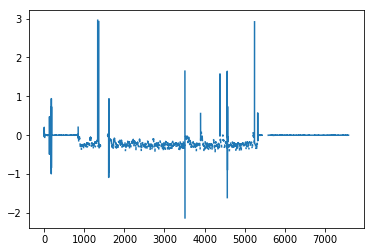

In [15]:
plt.plot(np.diff(np.arctan(tanA)))*wheelRadius

In [16]:
np.sum(np.abs(np.diff(np.arctan(tanA.dropna()))*wheelRadius))

48600.1554567502

#### Moving time

Get the total moving time, wheel plus non-wheel


In [17]:
totalTime = fid["frameinterval"]
movingTime = totalTime[fid["onlymouse"]].sum() + totalTime[fid["wheelmoving"]].sum()

print("recording time: " + str(totalTime.sum())+ " seconds")
print("total moving time: " + str(movingTime) + " seconds")
print("wheel moving time: "+ str(totalTime[fid["wheelmoving"]].sum())+ " seconds")
print("mouse moving time: " + str(totalTime[fid["onlymouse"]].sum())+ " seconds")
print("percentage of moving time spent on wheel: " + str(totalTime[fid["wheelmoving"]].sum()/movingTime))

recording time: 238.91964159999043 seconds
total moving time: 44.49887999991188 seconds
wheel moving time: 38.842483199900016 seconds
mouse moving time: 5.656396800011862 seconds
percentage of moving time spent on wheel: 0.8728867602954712


In [33]:
set(fid["mouse.Item1.mouse.Centroid.X"])

{9.673026}